# Open Loop: High Rep Rate

Sweeping over experimental diagnostic settings while keeping the experimental inputs relatively fixed.

In this demo, we will sweep over the photodetector delay time during 10 Hz systemwide operation. 

## Import necessary Python modules

In [4]:
import numpy as np
import epics # 'epics' is part of pyepics
from epics import PV
from time import sleep
import matplotlib.pyplot as plt

## Establish initial settings for LEDs, Photodetector, and Shutter

Our plan will be to run at 10 Hz, which means we will have 100 milliseconds to work with between each trigger.

Disable the shutter, since it doesn't operate this quickly.

In [5]:
epics.caput("SHUTTER:enable", 0) # Disable the shutter

1

Set all LEDs to flash at maximum brightness for 30 milliseconds.

In [6]:
NLEDS = 6 # our sidekick system has six LEDs
for i in range(NLEDS): # for each of our six LEDs
    epics.caput('LEDS:CH' + str(i) + ':brig.VAL', 255) # Set LED brightness to 255 out of 255 (max brightness)
    epics.caput('LEDS:CH' + str(i) + ':dur.VAL', 30.0e3) # Set LED 'flash on' duration to 30 ms

Set the photodetector exposure time to 1 millisecond, so we can identify the signal.

In [7]:
epics.caput("PHOTO:dur", 1.0e3) # Set photodetector exposure time to 1 ms

1

Configure the photodiode to begin exposure 5 milliseconds prior to the LED flash, so that it captures the entirety of the LED flash.

In [8]:
epics.caput("PULSEGEN:CH0:delay", 5.0e3) # Set LED trigger delay to 5 ms
epics.caput("PULSEGEN:CH2:delay", 0.0e3) # Set Photodetector trigger delay to 0 ms

1

Configure the pulse generator to output trigger pulses at 10 Hz.

In [9]:
epics.caput("PULSEGEN:reprate", 10) # Set systemwide repetition rate to 10 Hz

1

## Write parser to interpret photodetector data string

In [46]:
epics.caget("PHOTO:data")

'DAT: 0.000000000000, TRIG: 17054'

In [11]:
def dataparse(datastr):
    """ Parse the photodetector data string, which comes in the format 'DAT: 0.02112776, TRIG: 531' """
    [str1, str2] = datastr.split(',')
    data = np.float64(str1.split(': ')[1])
    trig = np.int64(str2.split(': ')[1])
    return data, trig

# Example usage:
dataparse("DAT: 0.009594346400, TRIG: 11")

(0.0095943464, 11)

In [12]:
dataparse(epics.caget("PHOTO:data"))

(0.0, 7956)

## Explore adding a callback to the photodetector data

In [59]:
pvphoto = PV("PHOTO:data.VAL", form="time")

In [65]:
def testCallback(pvname=None, value=None, **kw):
    data, trig = dataparse(value)
    print('New Photodetector Data! ', trig, data)

pvphoto.add_callback(testCallback)
sleep(1)
pvphoto.clear_callbacks()

New Photodetector Data!  23741 0.0
New Photodetector Data!  23742 0.0
New Photodetector Data!  23743 0.0
New Photodetector Data!  23744 0.0
New Photodetector Data!  23745 0.0
New Photodetector Data!  23746 0.0
New Photodetector Data!  23747 0.0
New Photodetector Data!  23748 0.0
New Photodetector Data!  23749 0.0
New Photodetector Data!  23750 0.0


## Sweep over photodetector trigger delays, recording data at each delay time

In [76]:
NSTEPS = 100 # We will explore brightness level in 100 distinct steps

delays = np.linspace(0.0e3, 60.0e3, NSTEPS).astype('int64') # Create a list NSTEPS long, that spans 0 to 255
data = np.zeros(NSTEPS) # allocate array to hold photodetector value for each brightness step
trigs = np.zeros(NSTEPS) # allocate array to hold trigger count corresponding to each photodetector value

isfresh = False # isfresh is a global variable indicating fresh data is ready to take

def dataCallback(pvname=None, value=None, **kw):
    global isfresh
    isfresh = True

pvphoto.add_callback(dataCallback)

for i in range(NSTEPS):
    epics.caput("PULSEGEN:CH2:delay", delays[i])
    isfresh = False
    while not isfresh:
        sleep(0.05)
    data[i], trigs[i] = dataparse(pvphoto.value)

pvphoto.clear_callbacks()

## Plot recorded data to reveal photodetector response curve

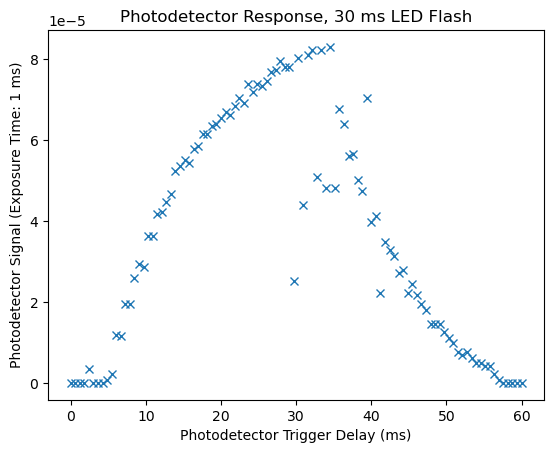

In [97]:
fig, ax = plt.subplots()
ax.plot(delays*1e-3, data, 'x')
ax.set_xlabel("Photodetector Trigger Delay (ms)")
#ax.set_ylim([0, 0.0015])
ax.set_ylabel("Photodetector Signal (Exposure Time: 1 ms)")
ax.set_title("Photodetector Response, 30 ms LED Flash")
plt.show()

## Examine Details of the Sweep Sequence

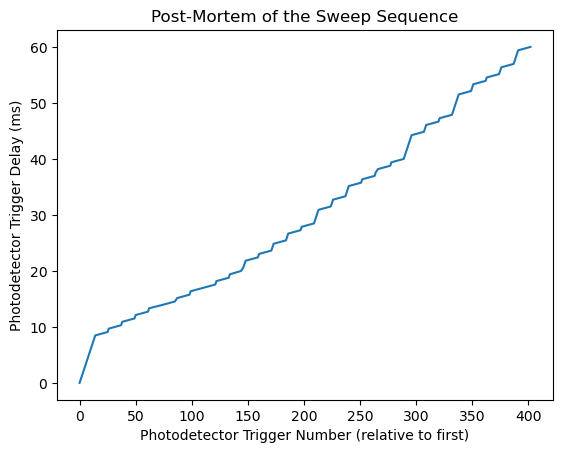

In [108]:
fig, ax = plt.subplots()
ax.plot(trigs - trigs[0], delays*1e-3, '-')
ax.set_xlabel("Photodetector Trigger Number (relative to first)")
#ax.set_ylim([0, 0.0015])
ax.set_ylabel("Photodetector Trigger Delay (ms)")
ax.set_title("Post-Mortem of the Sweep Sequence")
plt.show()

As you can see above, we discarded quite a bit of potential data! Our scan sequence spanned 400 systemwide triggers, but we only recorded photodetector data on 100 of these. Part of this is due to our insistence on "fresh data" after making each delay time change. Another reason may concern with how I asked pyepics to update variables via callback; future optimization is likely possible here.